In [5]:
import math
import scipy as sp
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from Additional_functions import dcpplot, Imp, compute_displacement
#from Additional_functions import quadri_boundaries


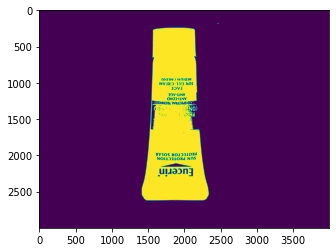

925


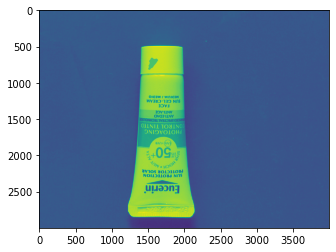

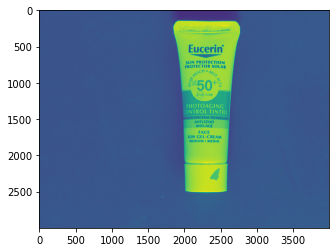

In [6]:
d1, d2, d3, d4 = Imp("Foto CV Coesia project/QueryD.jpg")
h1, h2, h3, h4 = Imp("Foto CV Coesia project/D3.jpg")
dd1, dd2, dd3, dd4 = Imp("Foto CV Coesia project/D6.jpg")

sift = cv2.xfeatures2d.SIFT_create()
FLANN_INDEX_KDTREE = 1
MIN_MATCH_COUNT = 350
kp_query = sift.detect(d2)
kp_query, des_query = sift.compute(d2, kp_query)
#Binarized the picture taken, let's find the right threshold that allows us
#to isolate well the white from the other colors
thresh_img = cv2.threshold(h3, 200, 255, cv2.THRESH_OTSU)[1]
plt.imshow(thresh_img)
plt.show()

image_height, image_width = h1.shape
kp_train = sift.detect(h2)
kp_train, des_train = sift.compute(h2, kp_train)
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_query,des_train,k=2) #k degree of freedom, number of nearest neighbours we have to evaluate

good = []
for m,n in matches:
    if m.distance < 0.8*n.distance: #0.9 degree of freedom, index of acceptability of a keypoint
        good.append(m)

h,w = d1.shape
print(len(good))
if len(good)>MIN_MATCH_COUNT:
# building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
# Using RANSAC to estimate a robust homography. 
# It returns the homography M and a mask for the discarded points

    M1, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 24.0)
        # Projecting the corners into the train image
    
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M1)

    DEN = cv2.polylines(h2,[np.int32(dst)],True, [255,0, 0],5, cv2.LINE_AA)

#dcpplot(h4, DEN, '0010', False, False, 1)
ddr3 = cv2.rotate(dd3, cv2.ROTATE_180)
plt.imshow(dd3)
plt.show()
plt.imshow(ddr3)
plt.show()

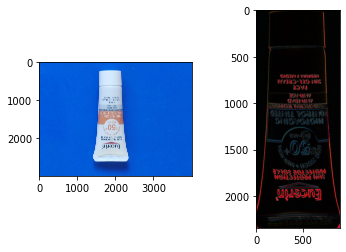

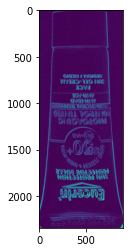

In [11]:
#Plot the differences

dst = dst.reshape(4,2)
dst = np.where(dst < 0, 0, dst)
dst = np.int32(dst)
h, w = np.shape(d3)

basex = dst[0,0]
basey = dst[0,1]
cut_img = h4[basey:basey+h,basex:basex+w]

diff = cv2.absdiff(cut_img, d4)
nd = np.where(diff > 100, (255, 0, 0), diff)
color_mask = np.all(nd == ([255, 0, 0]), axis=-1)
pixel_count = np.count_nonzero(color_mask)
cut_imgbn = cv2.cvtColor(cut_img, cv2.COLOR_RGB2GRAY)
gray_diff = cv2.absdiff(cut_imgbn, d3)
#plt.imshow(nd)
#plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(h4)
plt.subplot(1,2,2)
plt.imshow(nd)
plt.show()

plt.figure()
plt.imshow(gray_diff)
plt.show()




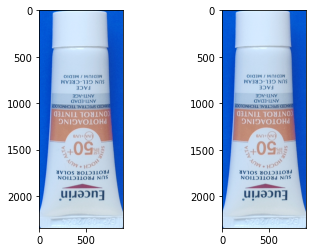

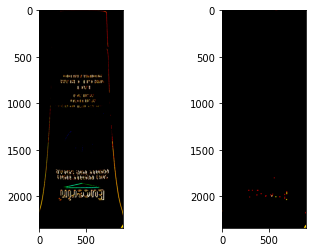

In [12]:
dst_pts = dst_pts.reshape(-1,2)
src_pts = src_pts.reshape(-1,2)
#compute displacement
src_adapted = src_pts+dst[0,:]
dx, dy = compute_displacement(src_adapted, dst_pts)
dx  = np.int32(dx)
dy = np.int32(dy)
absx = np.abs(dx)+1
absy = np.abs(dy)+1

if dx > 0:
    new_cut = cut_img[:, dx:]
    new_fil = d4[:, :-dx]
elif dx < 0:
    new_cut = cut_img[:, :-dx]
    new_fil = d4[:, dx:]

if dy > 0:
    new_cut = cut_img[dy:,:]
    new_fil = d4[:-dy, :]
elif dx < 0:
    new_cut = cut_img[:-dy, :]
    new_fil = d4[dy:, :]



difference_wt_displacement = cv2.absdiff(new_cut,new_fil)
binary_difference_wt_displacement = cv2.threshold(difference_wt_displacement, 100, 255, cv2.THRESH_BINARY)[1]
size_k = 9
kernel = np.zeros((size_k, size_k))
kernel[:] = 1
opened_diff = cv2.morphologyEx(binary_difference_wt_displacement, cv2.MORPH_OPEN, kernel )
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cut_img)
plt.subplot(1,2,2)
plt.imshow(new_cut)
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(binary_difference_wt_displacement)
plt.subplot(1,2,2)
plt.imshow(opened_diff)
plt.show()

Now implement the robustness of the algorithm wrt little moves of dentifricio, by removing all the dissimilar points next to the boundary. Start by computing the edge detector of both images and then remove the wrong points near the edge detector. We compute the edges and then apply a opening operator 

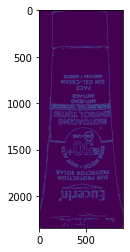

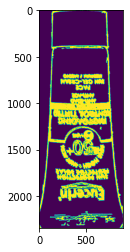

In [27]:
query_edge = cv2.Canny(d4, 80, 20, apertureSize = 3)
#plt.imshow(query_edge)
#plt.show()
img_edge = cv2.Canny(cut_img, 80, 20, apertureSize = 3)
plt.imshow(img_edge)
plt.show()

def Opener(image, size):
    h,w = np.shape(image)
    opimg = np.copy(image)
    for i in range (size, h -size):
        for j in range(size, w -size):
            if image[i,j] == 255:
                opimg[i-size:i+size,j-size:j+size] = 255
                #i = i +size
                #j = j+size

    return opimg


op_query = Opener(query_edge, 4)
#plt.imshow(op_query)
#plt.show()
op_img_edge = Opener(img_edge, 4)
#plt.imshow(op_img_edge)
#plt.show()

mask = op_img_edge +op_query
plt.imshow(mask)
plt.show()


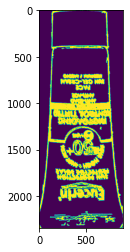

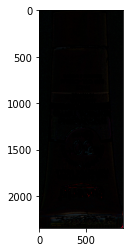

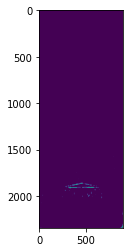

In [14]:
#Now modify the image with the mask
#Given that np.where requires that what we call nd and mask have same shape we create a new function
def cancel_borders(image_to_correct, image_giving_points):
    h,w = np.shape(image_giving_points)
    new_img = np.copy(image_to_correct)
    for i in range(0, w,1):
        for j in range(0,h,1):
            if image_giving_points[j,i] >= 254:
                new_img[j,i] = [0,0,0]

    return new_img


diff_wt_border = cancel_borders(nd, mask)

binary_wt_border = np.where(mask > 0, 0, binary_diff)
plt.imshow(mask)
plt.show()
plt.imshow(diff_wt_border)
plt.show()
plt.imshow(binary_wt_border)
plt.show()




Now let's provide a further opening operation on the differnce image with border in such a way to exclude the intra borders space  

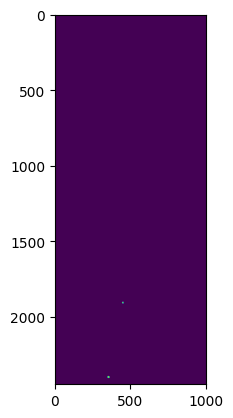

In [6]:
sizek = 9
kernel = np.zeros((sizek, sizek))
kernel[:] = 1
#Modify diff_wt_borders in order to make appliable the morphology operator


opened_diff = cv2.morphologyEx(binary_wt_border, cv2.MORPH_OPEN, kernel )
plt.imshow(opened_diff)
plt.show()

And finally classify it as defective if there is a certain percentage of this point. We decide athreshold of acceptability

In [7]:
acceptability = 0.05 #The 95% of the image should have non defects
ratio = np.count_nonzero(opened_diff)/(h*w)
if ratio >= acceptability:
    print("Product defectful")
else:
    print("Product ok")


Product ok


Instead, if the product is turned upside down, we found it from the coefficients of the Homography matrix. If the product is turned front back, the product obviously is non detected. We can provide a shape based detection to see wheter there's the product or just train another descriptor based on the feature of the back of the dentifricio and detect him. This second procedure is more reliable altough is more computationally expensive. If we don't find nor front or back we declare the product not found

Doing this we also enlarge too much the center of the toothpaste, while we need mostly a mask for the borders

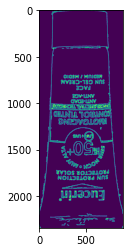

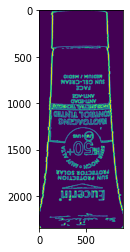

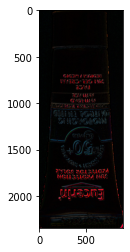

In [26]:
def enlarge_borders(edge, size):
    borders = []
    output = np.copy(edge)
    h,w =  np.shape(edge)
    for i in range(0, h, 1):
        for j in range(size, w-size, 1):
            if edge[i,j] == 255:
                output[i,j-size:j+size] = 255
                break

        for j in range(w-size, size, -1):
            if edge[i,j] == 255:
                output[i,j-size:j+size] = 255
                break


    return output


kedge = np.zeros((3,3))
kedge[:] = 1
dilated_edge = cv2.morphologyEx(img_edge, cv2.MORPH_DILATE, kedge) 
plt.imshow(dilated_edge)
plt.show()
enlarge = enlarge_borders(dilated_edge,7)
new_diff_wt_borders = cancel_borders(nd, enlarge)
plt.imshow(enlarge)
plt.show()

plt.imshow(new_diff_wt_borders)
plt.show()